# Imports

In [1]:
import logging
import shutil
import sys
from os.path import isdir, join
from tempfile import gettempdir
from uuid import uuid4

import folium
import pandas as pd
import geopandas as gpd
from aequilibrae import Parameters, Project, logger

from functions.basic_stats import basic_stats
from functions.bridge_stats import bridge_stats
from functions.toll_stats import toll_stats
from functions.tunnel_stats import tunnel_stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/saturn/share/proj failed


# Model place (Country) to build the model for

In [2]:
model_place = 'Andorra'

In [3]:
fldr = f'../../../{model_place}'

if isdir(fldr):
    print(fldr)

../../../Andorra


# Open Model

In [4]:
project = Project()
project.open(fldr)

# Get model data

And filters only to links accessible to cars

In [5]:
links = project.network.links.data
links = links[links.modes.str.contains('c')]

# Print statistics

In [6]:
basic_stats(links)

----- Links -----

|   General |   Bridge |   Toll |   Tunnel |   Total |
|-----------|----------|--------|----------|---------|
|      4641 |      288 |     15 |       63 |    5007 |

----- Total km -----

|   General |   Bridge |   Toll |   Tunnel |   Total |
|-----------|----------|--------|----------|---------|
|    478.20 |     7.54 |   4.49 |    16.55 |  506.77 |

----- Link Type -----

| Link Type     |   Links |     km |
|---------------|---------|--------|
| living_street |      54 |   2.02 |
| primary       |    1225 | 117.03 |
| residential   |    1449 | 114.44 |
| secondary     |     910 | 145.93 |
| service       |     856 |  57.68 |
| tertiary      |     296 |  42.80 |
| trunk         |      63 |  12.82 |
| unclassified  |     153 |  13.71 |
| via_ferrata   |       1 |   0.34 |

----- Pavement Surfaces -----

| Surface Type   |   Links |     km |
|----------------|---------|--------|
| asphalt        |    2760 | 341.95 |
| compacted      |       2 |   0.53 |
| concrete   

In [7]:
bridge_stats(links)

----- Bridge - Overall Stats -----
 
|        |   Links |        km |
|--------|---------|-----------|
| Bridge |     288 |   7536.45 |
| Total  |    5007 | 506772.07 |
 
There are no toll bridges in the search area.

----- Bridge - Link Type -----

| Link Type     |   Links |   km |
|---------------|---------|------|
| living_street |       1 | 0.01 |
| primary       |     106 | 3.42 |
| residential   |      57 | 0.89 |
| secondary     |      57 | 1.21 |
| service       |      29 | 0.54 |
| tertiary      |      11 | 0.11 |
| trunk         |      12 | 1.06 |
| unclassified  |      15 | 0.29 |

----- Bridge - Pavement Surface -----

| Surface Type   |   Links |   km |
|----------------|---------|------|
| asphalt        |     185 | 5.27 |
| unclassified   |     103 | 2.26 |



In [8]:
toll_stats(links)

----- Tolls - Overall Stats -----
 
|       |   Links |     km |
|-------|---------|--------|
| Tolls |      15 |   4.49 |
| Total |    5007 | 506.77 |
 
----- Tolls - Link Type -----

| Link Type   |   Links |   km |
|-------------|---------|------|
| primary     |       2 | 0.22 |
| trunk       |      13 | 4.27 |

----- Tolls - Pavement Surfaces -----

| Surface Type   |   Links |   km |
|----------------|---------|------|
| asphalt        |      15 | 4.49 |



In [ ]:
tunnel_stats(links)

----- Tunnels - Overall Stats -----
 
|         |   Links |     km |
|---------|---------|--------|
| Tunnels |      68 |  16.62 |
| Total   |    5168 | 508.01 |
 
----- Toll Tunnels -----
 
|   links |   km |
|---------|------|
|       2 | 2.96 |

----- Tunnels - Link Type -----

| Link Type     |   Links |   km |
|---------------|---------|------|
| living_street |       4 | 0.03 |
| primary       |      16 | 3.65 |
| residential   |       4 | 0.14 |
| secondary     |       2 | 0.08 |
| service       |      24 | 3.49 |
| tertiary      |       4 | 0.37 |
| trunk         |       9 | 8.81 |
| unclassified  |       5 | 0.05 |

----- Tunnels - Pavement Surfaces -----

| Surface Type   |   Links |    km |
|----------------|---------|-------|
| asphalt        |      33 | 13.02 |
| unclassified   |      35 |  3.61 |



# We map the total network distance per subdivision

In [12]:
sql = "SELECT division_name, level, Hex(ST_AsBinary(GEOMETRY)) as geom FROM country_subdivisions;"
subdivisions = gpd.GeoDataFrame.from_postgis(sql, project.conn, geom_col="geom", crs=4326)
# subdivisions.set_crs('epsg:4326', inplace=True)
subdivisions = subdivisions[subdivisions.level==1]

In [13]:
links=gpd.GeoDataFrame(links, geometry='geometry', crs=4326)
data = gpd.sjoin(links, subdivisions)
sum_distance = data.groupby(['division_name']).sum()[['distance']].reset_index()

<AxesSubplot:>

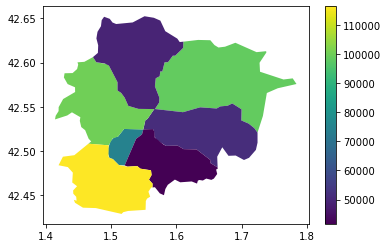

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
plot_data = subdivisions.merge(sum_distance, on='division_name')
plot_data.plot(column='distance', ax=ax, legend=True)

In [10]:
project.close()